In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import os
import numpy as np
import pandas as pd
import scipy
import anndata
import scanpy as sc
import pybiomart
import scvi
import torch
import random
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cwd = os.getcwd()
cwd

'/Users/deanlee/GitHub/FigureOneLab/example_projects/human_microglia_brain_organoids'

In [3]:
kracht = sc.read_h5ad(cwd+'/outs/240201_kracht_scvi.h5ad')
trevino = sc.read_h5ad(cwd+'/outs/240301_trevino_microglia.h5ad')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [4]:
trevino.obs['ConceptionalAgeWeek'] = trevino.obs['Age'].str.replace('pcw','').astype(int)
trevino.obs['GestationalAgeDay'] = 7*trevino.obs['ConceptionalAgeWeek']+14
trevino.obs['SampleID'] = trevino.obs['Sample.ID']

In [5]:
adata = anndata.concat([kracht, trevino], join='outer')
adata.obs_names_make_unique()
adata

AnnData object with n_obs × n_vars = 17509 × 23810
    obs: 'CellID', 'SampleID', 'PatientID', 'PatientID_SampleID', 'SampleID_CellID', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'percent_mt', '_scvi_batch', '_scvi_labels', 'leiden_scvi', 'Sex', 'GestationalAgeDay', 'Cell.ID', 'Sample.ID', 'Age', 'Tissue.ID', 'Sample.Type', 'Assay', 'Batch', 'seurat_clusters', 'RNA.Counts', 'RNA.Features', 'Percent.MT', 'Percent.Ribo', 'Cell.Barcode', 'DF_pANN', 'DF_classification', 'DF_pANN_quantile', 'Spliced.Counts', 'Spliced.Features', 'Unspliced.Counts', 'Unspliced.Features', 'Ambiguous.Counts', 'Ambiguous.Features', 'CellType', 'ConceptionalAgeWeek'
    obsm: 'X_scvi', 'X_umap'
    layers: 'counts', 'counts_scvi', 'log2_counts', 'log2_counts_scvi'

In [6]:
#adata = sc.read_h5ad(cwd+'/outs/240201_kracht_scvi.h5ad')
#adata

In [7]:
%%time
random.seed(17)
scvi.model.SCVI.setup_anndata(adata, layer='counts', batch_key='SampleID')
scvi_model = scvi.model.SCVI(adata, n_layers=2, n_latent=30, n_hidden=128, gene_likelihood='nb')
scvi_model.train()

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Epoch 400/400: 100%|█| 400/400 [4:06:01<00:00, 16.32s/it, v_num=1, train_loss_st

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|█| 400/400 [4:06:02<00:00, 36.91s/it, v_num=1, train_loss_st
CPU times: user 6h 51min 43s, sys: 1h 4min 47s, total: 7h 56min 31s
Wall time: 4h 6min 5s


In [8]:
%%time
random.seed(17)
adata.obsm['X_scvi'] = scvi_model.get_latent_representation()
adata.layers['counts_scvi'] = scvi_model.get_normalized_expression(library_size=10000)
#adata.layers['log2_counts_scvi'] = sc.pp.log1p(adata.layers['counts_scvi'].copy(), base=2)

CPU times: user 9.6 s, sys: 4.61 s, total: 14.2 s
Wall time: 10.7 s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


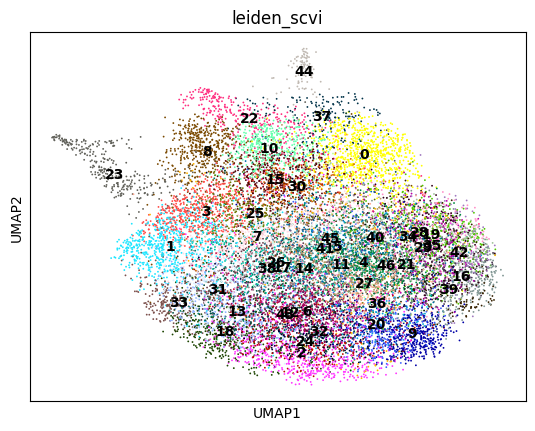

CPU times: user 40.1 s, sys: 1.32 s, total: 41.4 s
Wall time: 36.9 s


In [9]:
%%time
random.seed(17)
sc.pp.neighbors(adata, use_rep='X_scvi', key_added='neighbors_scvi', n_neighbors=20)
sc.tl.leiden(adata, neighbors_key='neighbors_scvi', key_added='leiden_scvi', resolution=3)
sc.tl.umap(adata, neighbors_key='neighbors_scvi')
sc.pl.umap(adata, color=['leiden_scvi'], legend_loc='on data')

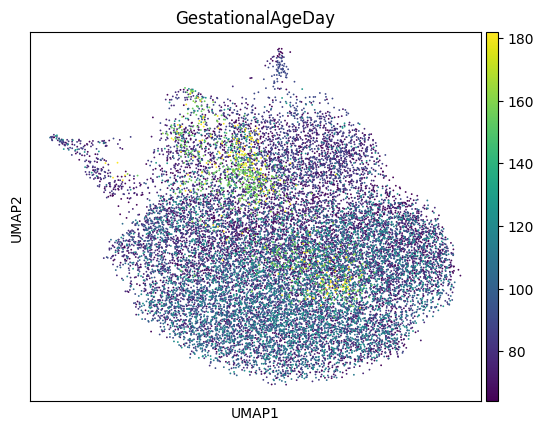

In [10]:
sc.pl.umap(adata, color=['GestationalAgeDay'])

In [11]:
def GetBootstrapCells(adata, goi, layer='counts', bootstrap_size=10):

    df = sc.get.obs_df(adata, keys=goi, layer=layer)
    df['PatientID'] = adata.obs['PatientID']

    bootstrap_cell_dict = {}
    count = 1
    m = df['PatientID'].value_counts().max() # number of cells in PatientID with largest number of cells
    n = math.floor(round(m/bootstrap_size, 2)) # greatest number of BootstrapCells possible
    for i in range(n):

        bootstrap_cell = df.groupby('PatientID').sample(bootstrap_size)

        df = df[~df.index.isin(bootstrap_cell.index)] # sample without replacement

        bootstrap_cell = bootstrap_cell.groupby('PatientID').sum()
        bootstrap_cell['BootstrapCellID'] = bootstrap_cell.index.astype(str) + '_' + str(count)

        bootstrap_cell_dict[count] = bootstrap_cell

        # If number of cells left in a PatientID is less than bootstrap_size, remove those cells
        a  = df['PatientID'].value_counts() < bootstrap_size
        if sum(a)>0:
            b = df['PatientID'].value_counts()[a].index.tolist()
            c = df['PatientID'].isin(b)
            df = df[~c]
            df['PatientID'] = df['PatientID'].cat.remove_unused_categories()

        count = count + 1

    bootstrap_cells = pd.concat(bootstrap_cell_dict.values())
    bootstrap_cells['PatientID'] = bootstrap_cells.index.astype(str)
    bootstrap_cells.index.name = None
    bootstrap_cells = pd.merge(bootstrap_cells, 
                               adata.obs[['PatientID','GestationalAgeDay']].drop_duplicates(),
                               on='PatientID', how='left')
    bootstrap_cells.rename(columns={'GestationalAgeDay':'Age'}, inplace=True)
    bootstrap_cells
    
    return bootstrap_cells

In [12]:
def BootstrapCellsRegression(bootstrap_cells, goi, response='Age', regression='lasso', alpha=0.5,
                             x_label='Predicted Age (Days)', y_label='Age (Days)'):
    X = bootstrap_cells[goi]
    y = bootstrap_cells[response]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=10)

    if regression=='lasso': reg = Lasso(alpha=alpha)
    if regression=='ridge': reg = Ridge(alpha=alpha)
    if regression=='elasticnet': reg = ElasticNet(alpha=alpha)
    reg.fit(X_train, y_train)
    print('R squared training set', round(reg.score(X_train, y_train)*100, 2))
    print('R squared test set', round(reg.score(X_test, y_test)*100, 2))

    # train
    pred_train = reg.predict(X_train)
    mse_train = mean_squared_error(y_train, pred_train)
    print('MSE training set', round(mse_train, 2))

    # test
    pred_test = reg.predict(X_test)
    mse_test = mean_squared_error(y_test, pred_test)
    print('MSE test set', round(mse_test, 2))

    plt.figure()
    sns.scatterplot(x=pred_test, y=y_test)
    r, p = scipy.stats.pearsonr(x=pred_test, y=y_test)
    ax = plt.gca() # get a matplotlib axes instance
    plt.text(.05, .9, "Pearson's r ={:.2f}".format(r), transform=ax.transAxes)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    
    return reg, X_train

In [46]:
# test different ways to select genes as predictor variables
# exclude MT-, RPS-, RPL- genes
gene_sums = pd.DataFrame(adata.layers['counts_scvi'].sum(axis=0))
index = (gene_sums > 100000)[0]
goi = adata.var_names[index].tolist()
print(len(goi))

df = pd.DataFrame(goi)
df.rename(columns={0:'Genes'}, inplace=True)
a = df['Genes'].str.contains(r'^MT-|^RPS|^RPL')
df = df[~a]
goi = df['Genes'].tolist()
print(len(goi))

239
201


In [47]:
goi = [x for x in goi if x not in ['H3-3B', 'MARCHF6', 'MTATP6P1', 'MTCO1P12', 'RNA5SP151', 'TMSB4XP4']]
print(len(goi))

195


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.270e+03, tolerance: 2.681e+01
  model = cd_fast.enet_coordinate_descent(


R squared training set 98.42
R squared test set 97.77
MSE training set 5.13
MSE test set 8.19


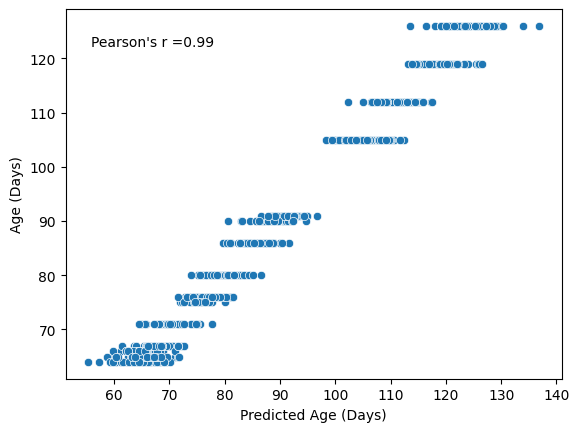

In [48]:
bootstrap_cells = GetBootstrapCells(adata, goi=goi, layer='counts_scvi', bootstrap_size=10)
model, X_train = BootstrapCellsRegression(bootstrap_cells, goi, response='Age', regression='elasticnet', alpha=0.5)

In [49]:
a = pd.DataFrame({'Gene':X_train.columns.tolist(),'Coefficient':model.coef_})
a['AbsoluteCoefficient'] = abs(a['Coefficient'])
a = a.sort_values(by='AbsoluteCoefficient', ascending=False)
a['Gene'][0:20].tolist()

['CHD7',
 'PABPC1',
 'UBE2W',
 'SRGAP2C',
 'SMU1',
 'GRB2',
 'TLE3',
 'HSP90AB1',
 'GOLIM4',
 'CASP2',
 'SLCO2B1',
 'HTRA1',
 'YWHAE',
 'KLF6',
 'MEF2C',
 'CD74',
 'ZFP36L1',
 'PPP2R5C',
 'RAB12',
 'ARPC5']

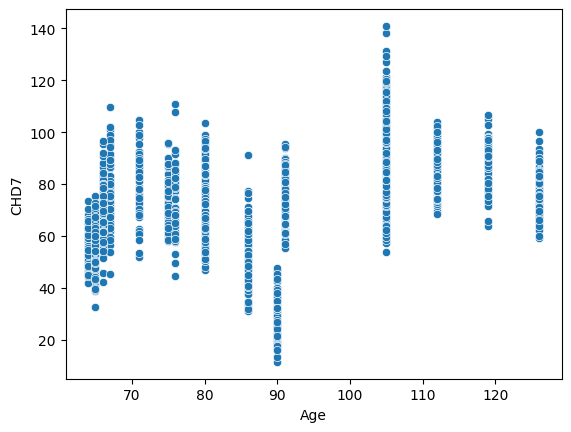

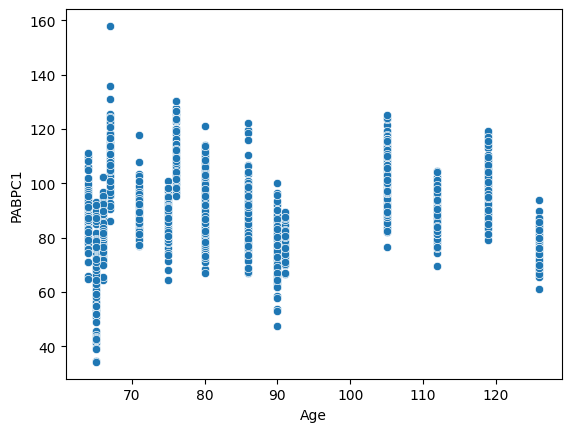

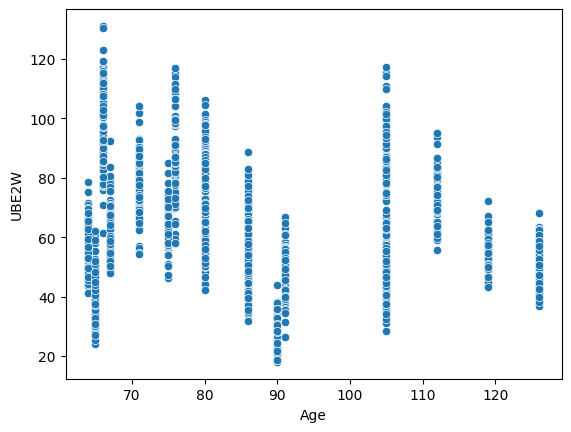

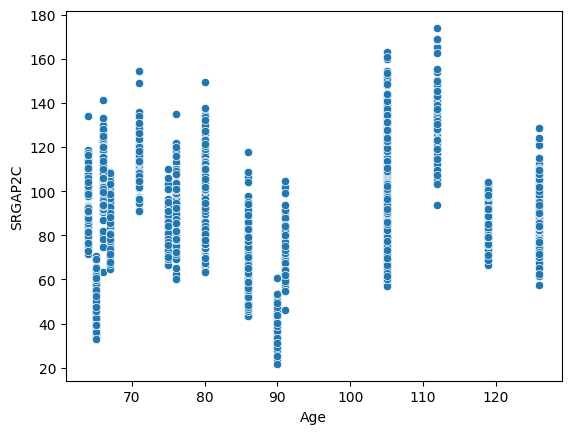

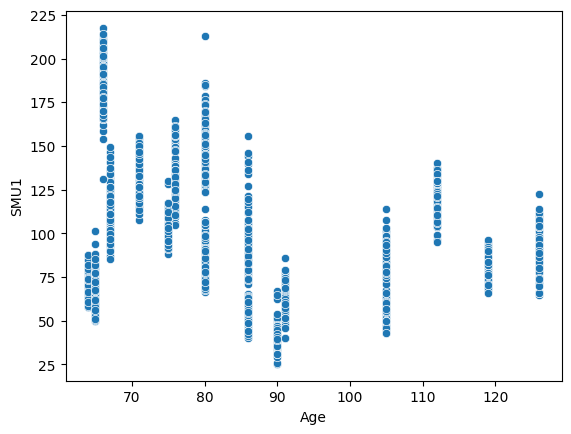

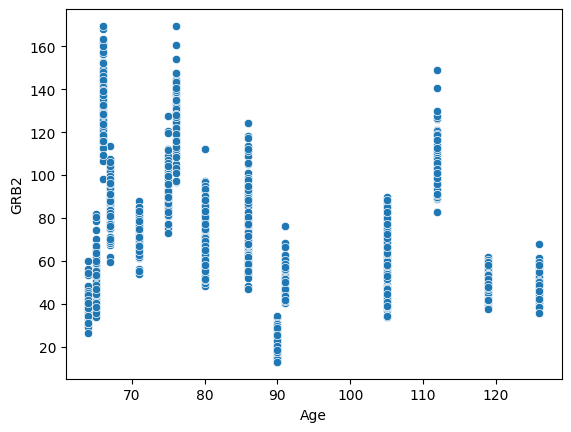

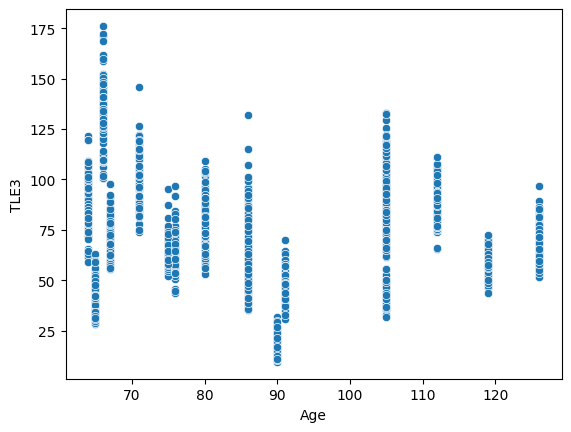

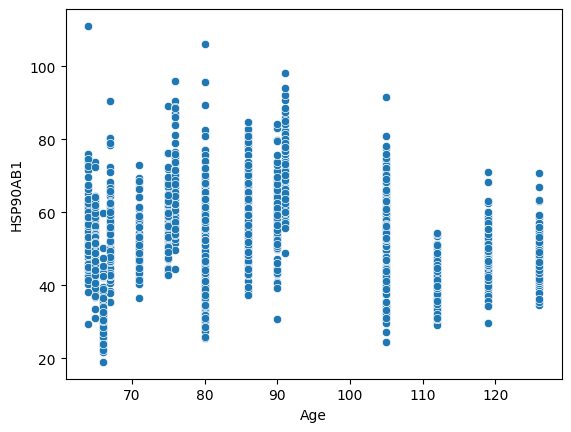

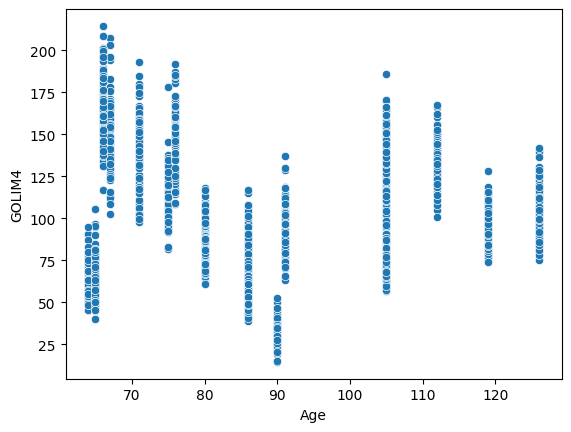

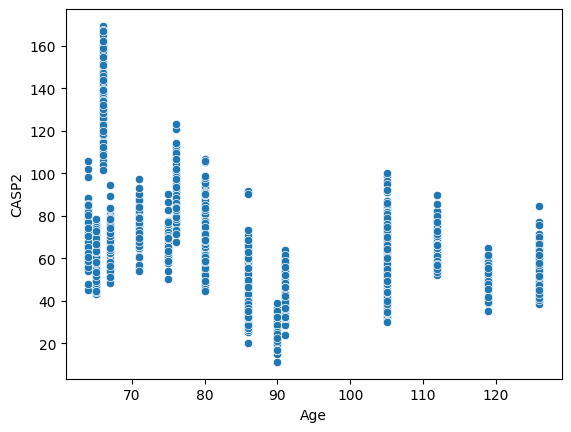

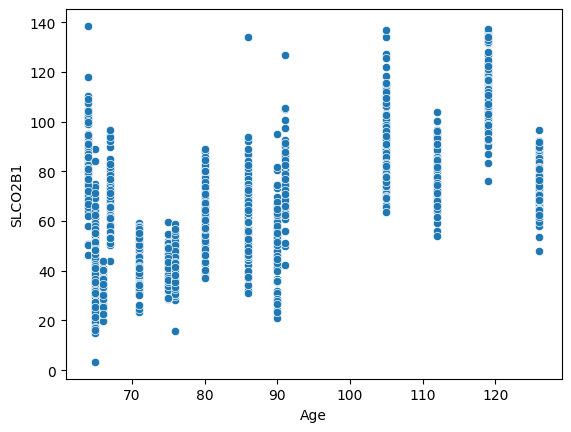

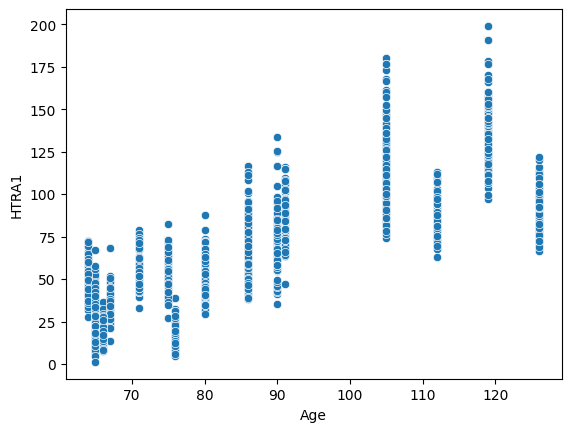

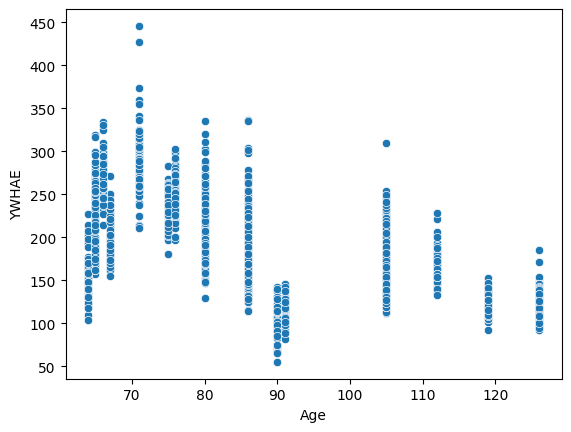

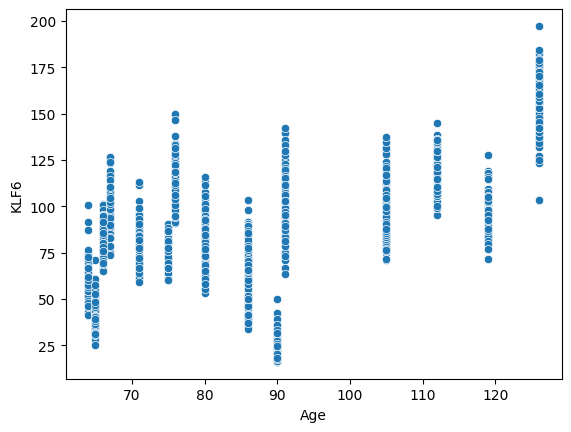

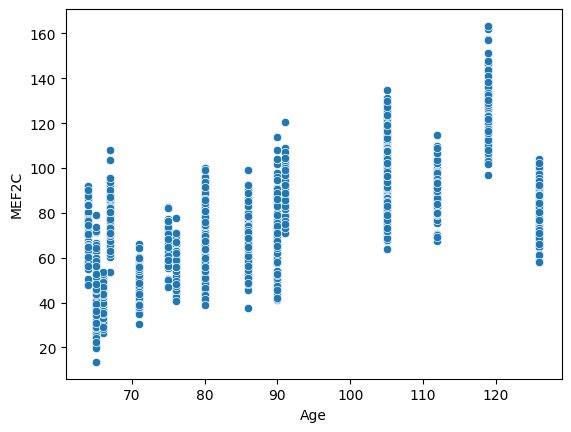

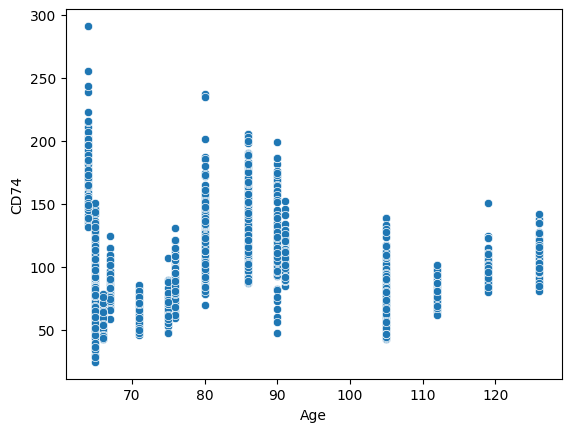

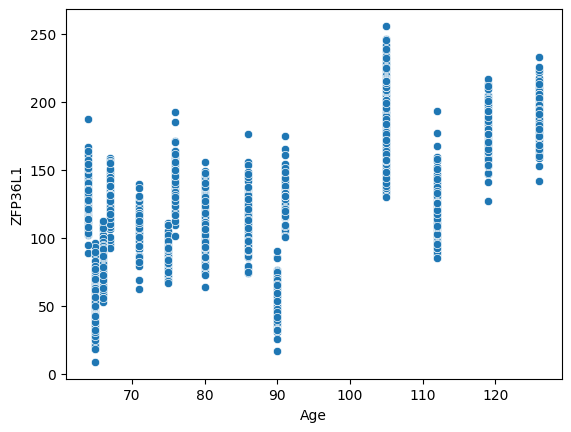

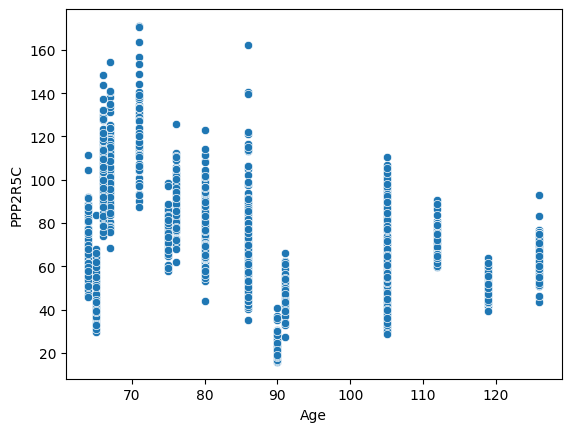

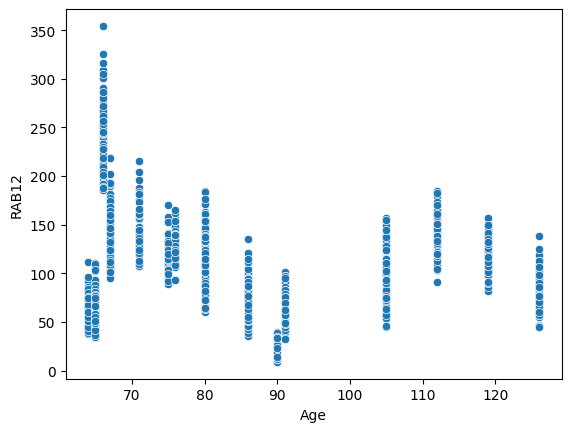

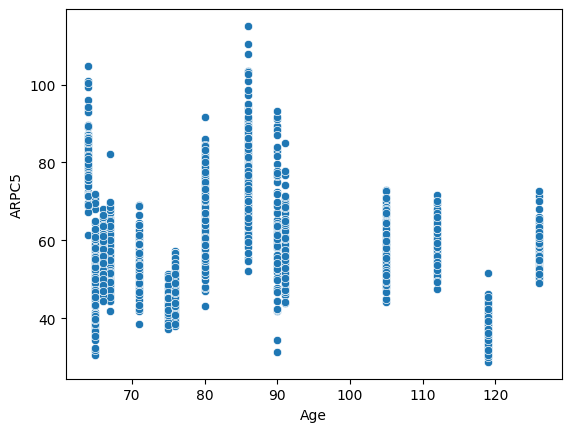

In [50]:
for i in a['Gene'][0:20].tolist():
    plt.figure()
    sns.scatterplot(bootstrap_cells, x='Age', y=i)

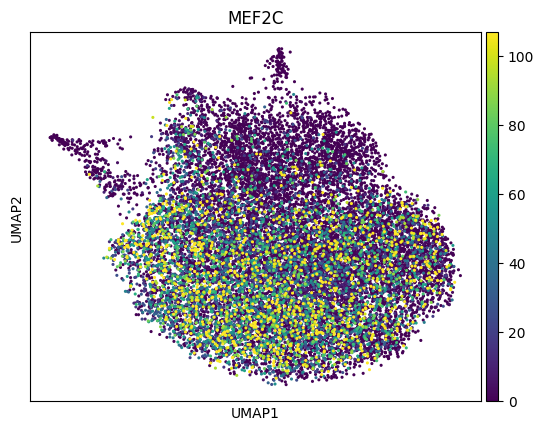

In [51]:
sc.pl.umap(adata, color=['MEF2C'], vmax='p95', vmin='p5', size=20)

In [52]:
#BootstrapCell uses a lasso model with the following characteristics: 
#To generate a BootstrapCell, 15 single-cell transcriptomes were sampled without replacement from the pool of cells
#of a given cell type from a given animal (for example, oligodendrocytes from a single mouse). Gene counts were 
#then summed. A BootstrapCell constructed from 15 cells was empirically found to balance the tradeoff between sample
#number and gene coverage per sample. This bootstrapping process was repeated 100 times for each cell type–animal 
#combination. BootstrapCells were used as input into lasso regression models. This approach had the effect of 
#normalizing the contribution of each animal rather than each single-cell transcriptome.

# assess age of human microglia cultured alone (MGL) or co-cultured with brain organoid (COC)

In [134]:
speicher = sc.read_h5ad(cwd+'/outs/240201_speicher_microglia_scvi.h5ad')
speicher

AnnData object with n_obs × n_vars = 2483 × 20575
    obs: 'CellID', 'CellType', 'SampleID', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'percent_mt', '_scvi_batch', '_scvi_labels', 'leiden_scvi'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'SampleID_colors', '_scvi_manager_uuid', '_scvi_uuid', 'leiden', 'neighbors_scvi', 'umap'
    obsm: 'X_scvi', 'X_umap'
    layers: 'counts', 'counts_scvi'
    obsp: 'neighbors_scvi_connectivities', 'neighbors_scvi_distances'

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


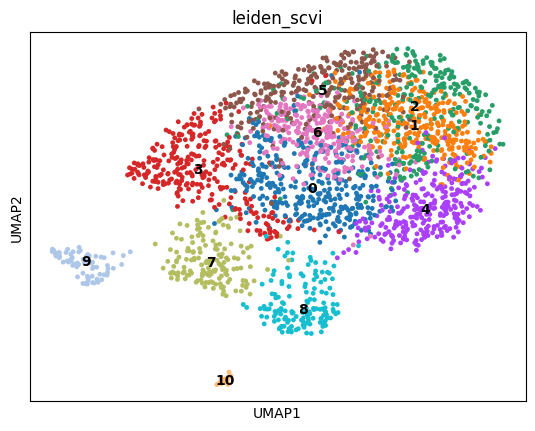

In [135]:
random.seed(17)
sc.pp.neighbors(speicher, use_rep='X_scvi', key_added='neighbors_scvi', n_neighbors=40)
sc.tl.leiden(speicher, neighbors_key='neighbors_scvi', key_added='leiden_scvi', resolution=1)
sc.tl.umap(speicher, neighbors_key='neighbors_scvi')
sc.pl.umap(speicher, color=['leiden_scvi'], legend_loc='on data')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


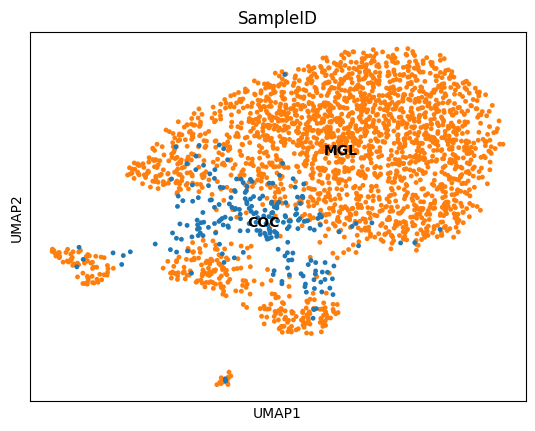

In [136]:
sc.pl.umap(speicher, color=['SampleID'], legend_loc='on data')

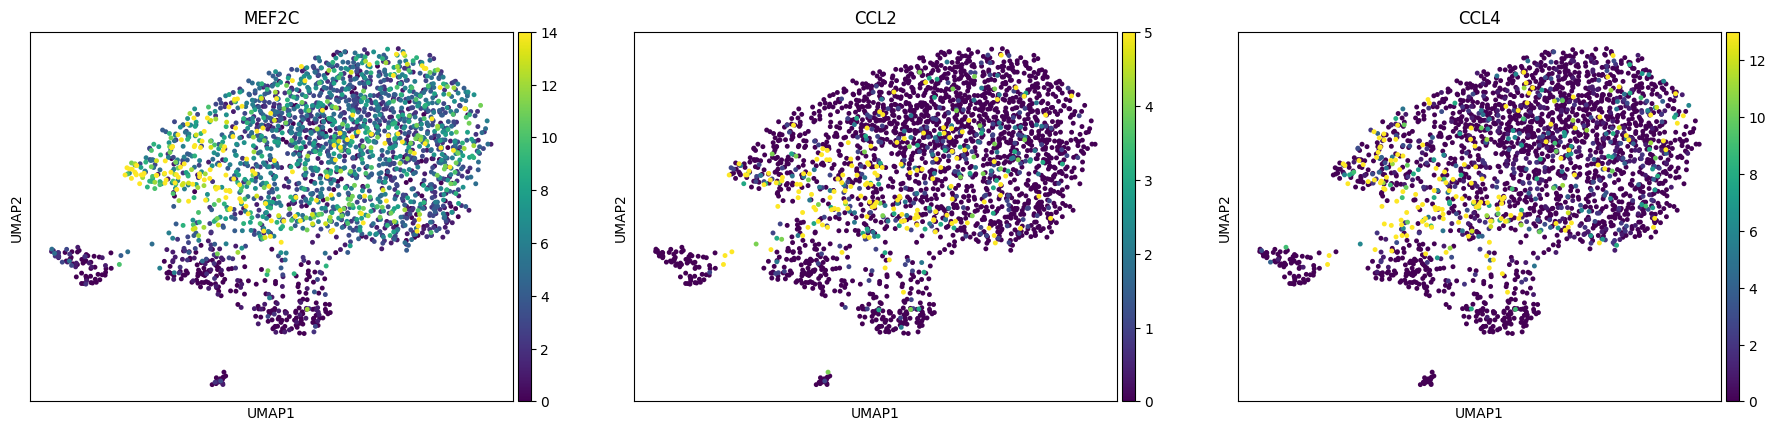

In [141]:
sc.pl.umap(speicher, color=['MEF2C', 'CCL2', 'CCL4'], vmax='p95', vmin='p5', size=50)

In [138]:
speicher.obs['PatientID'] = speicher.obs['SampleID']
speicher.obs['GestationalAgeDay'] = speicher.obs['SampleID']

In [139]:
bootstrap_cells = GetBootstrapCells(speicher, goi=goi, layer='counts_scvi', bootstrap_size=10)
X = bootstrap_cells[goi]
pred = model.predict(X)

<Axes: xlabel='Group', ylabel='PredictedAgeDay'>

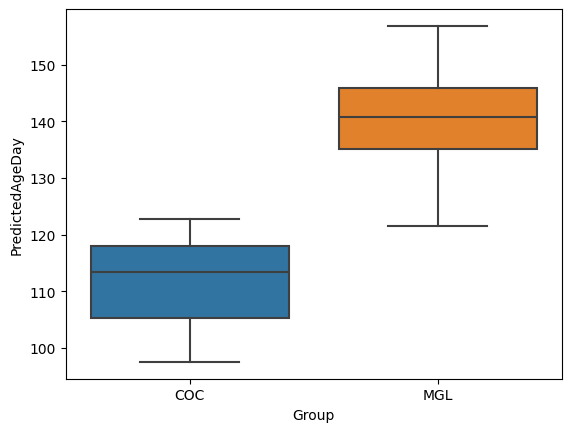

In [140]:
df = pd.DataFrame({'Group':bootstrap_cells['PatientID'], 'PredictedAgeDay':pred})
sns.boxplot(data=df, x='Group', y='PredictedAgeDay')

#sns.scatterplot(x=pred, y=y_test)
#plt.xlabel(x_label)
#plt.ylabel(y_label)